In [1]:
#basic
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

#torchvision
import torchvision
from torchvision import transforms, datasets

from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import shutil
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)


PyTorch version in use: 2.4.1+cu118 
cuda avail:  True


C:\Users\ricig\AppData\Local\Temp\ipykernel_20032\3372247548.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Device: cuda


In [ ]:
file_path = "./Dataset_Truss_SysId_Gap9/sysid/"
file_pattern = "anomaly_{}.csv"

# Initialize an empty list to store DataFrames
df_list = []

# Loop through the files and read them into DataFrames
for i in range(1, 10):
    file_name = file_path + file_pattern.format(i)
    df = pd.read_csv(file_name, header=None, skiprows=1)
    df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
#print(combined_df)
print(df_list[0])


In [ ]:
# Convert DataFrame to a NumPy array
data_array = combined_df.to_numpy()

# Flatten the array
flattened_array = data_array.flatten()

num_elements = len(flattened_array)
num_1x500_arrays = num_elements // 500

# Only include full 1x500 arrays
anomaly_reshaped_array = flattened_array[:num_1x500_arrays * 500].reshape(-1, 500)
# Print the shape to verify
print(anomaly_reshaped_array.shape)
print(anomaly_reshaped_array)


In [ ]:
file_path = "./Dataset_Truss_SysId_Gap9/sysid/"
file_pattern = "anomaly_{}.csv"

# Initialize an empty dictionary to store DataFrames
df_dict = {}

# Initialize an empty dictionary to store reshaped arrays
reshaped_arrays_dict = {}

# Loop through the files and read them into DataFrames
for i in range(1, 10):
    file_name = file_path + file_pattern.format(i)
    df = pd.read_csv(file_name, header=None, skiprows=1)
    df_dict[i] = df  # Save each DataFrame in the dictionary with the file number as the key
    
    # Convert DataFrame to a NumPy array
    data_array = df.to_numpy()
    
    # Flatten the array
    flattened_array = data_array.flatten()
    
    num_elements = len(flattened_array)
    num_1x500_arrays = num_elements // 500
    
    # Only include full 1x500 arrays
    reshaped_array = flattened_array[:num_1x500_arrays * 500].reshape(-1, 500)
    
    # Store the reshaped array in the dictionary
    reshaped_arrays_dict[i] = reshaped_array

# Example: Display the shape of the reshaped arrays to verify
for key, array in reshaped_arrays_dict.items():
    print(f"Reshaped Array {key} shape: {array.shape}")

# Example: Access and display a specific reshaped array
example_reshaped_array = reshaped_arrays_dict[1]
print(f"\nExample Reshaped Array 1:\n{example_reshaped_array}")


In [ ]:
file_path = "./Dataset_Truss_SysId_Gap9/sysid/"

# Initialize an empty list to store DataFrames
df_list = []

df = pd.read_csv(file_path+"x_test.csv", header=None, skiprows=1)
df_list.append(df)
df = pd.read_csv(file_path+"x_train.csv", header=None, skiprows=1)
df_list.append(df)
df = pd.read_csv(file_path+"x_validation.csv", header=None, skiprows=1)
df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df)


In [ ]:
# Convert DataFrame to a NumPy array
data_array = combined_df.to_numpy()

# Flatten the array
flattened_array = data_array.flatten()

num_elements = len(flattened_array)
num_1x500_arrays = num_elements // 500

# Only include full 1x512 arrays
ok_reshaped_array = flattened_array[:num_1x500_arrays * 500].reshape(-1, 500)
# Print the shape to verify
print(ok_reshaped_array.shape)
print(ok_reshaped_array)


In [ ]:
def save_arrays_labeled(reshaped_array, output_directory, label):
    # Loop through each row in the reshaped array
    for i in range(reshaped_array.shape[0]):
        # Extract the current 1x500 array
        single_array = reshaped_array[i]
        
        # Define the file name for the output
        file_name = f'{output_directory}/array_{i}_{label}.npy'
        
        # Save the array as a .npy file
        np.save(file_name, single_array)


In [ ]:
output_directory = './output_arrays_labeledanomalies'

if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

os.makedirs(output_directory)

# Call the function to save the arrays
for i in range(1, 10):
    save_arrays_labeled(reshaped_arrays_dict[i], output_directory, i)
save_arrays_labeled(ok_reshaped_array, output_directory, 0)

In [ ]:
reshaped_arrays_dict = []
ok_reshaped_array = []

# If provided dataset, start from here

In [2]:
def load_dataset_and_labels(directory):
    # Initialize lists to hold the data and labels
    data = []
    labels = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            # Load the .npy file
            array = np.load(os.path.join(directory, filename))
            
            # Extract the label from the filename
            label = int(filename.split('_')[2].split('.')[0])
            
            # Append the array and label to the respective lists
            data.append(array)
            labels.append(label)
    
    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

output_directory = './output_arrays_labeledanomalies'
# Call the function to load the dataset and labels
data, labels = load_dataset_and_labels(output_directory)

data = (data - data.mean()) / data.std()

# Print shapes to verify
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print(labels)


Data shape: (140676, 500)
Labels shape: (140676,)
[0 1 2 ... 7 8 9]


In [3]:
# Separate the data and labels into majority (label 0) and minority classes
majority_class_data = data[labels == 0]
majority_class_labels = labels[labels == 0]

minority_class_data = data[labels != 0]
minority_class_labels = labels[labels != 0]

# Combine majority data and labels into a single array for undersampling
combined_majority_data = majority_class_data.reshape(-1, majority_class_data.shape[-1])
combined_majority_labels = majority_class_labels

# Set the desired ratio of the majority class to the minority classes
undersample_ratio = len(minority_class_labels) // len(np.unique(minority_class_labels))

# Randomly select indices for undersampling the majority class
undersample_indices = np.random.choice(len(majority_class_data), size=undersample_ratio, replace=False)
majority_class_data_undersampled = majority_class_data[undersample_indices]
majority_class_labels_undersampled = majority_class_labels[undersample_indices]

# Combine the undersampled majority class with the minority classes
data_resampled = np.vstack((majority_class_data_undersampled, minority_class_data))
labels_resampled = np.hstack((majority_class_labels_undersampled, minority_class_labels))

# Print shapes to verify
print("Data shape:", data_resampled.shape)
print("Labels shape:", labels_resampled.shape)

# Convert resampled data to tensors
data_tensor_resampled = torch.tensor(data_resampled, dtype=torch.float32)
labels_tensor_resampled = torch.tensor(labels_resampled, dtype=torch.long)

Data shape: (80128, 500)
Labels shape: (80128,)


In [4]:
def uniform_undersample(data, labels, target_per_class=2000):
    """
    For each unique label, randomly select target_per_class samples.
    If a class has fewer samples than target_per_class, sampling is done with replacement.
    """
    unique_classes = np.unique(labels)
    undersampled_data = []
    undersampled_labels = []
    
    for c in unique_classes:
        # Find the indices for the current class
        class_indices = np.where(labels == c)[0]
        
        # If enough samples exist, sample without replacement; otherwise, sample with replacement.
        if len(class_indices) >= target_per_class:
            selected_indices = np.random.choice(class_indices, size=target_per_class, replace=False)
        else:
            selected_indices = np.random.choice(class_indices, size=target_per_class, replace=True)
        
        undersampled_data.append(data[selected_indices])
        undersampled_labels.append(labels[selected_indices])
    
    # Stack the arrays so that the final dataset has target_per_class samples for each class
    final_data = np.vstack(undersampled_data)
    final_labels = np.hstack(undersampled_labels)
    
    return final_data, final_labels

# Assuming data_resampled and labels_resampled have been created from your previous code:
data_uniform, labels_uniform = uniform_undersample(data_resampled, labels_resampled, target_per_class=2000)

print("Uniform data shape:", data_uniform.shape)
print("Uniform labels shape:", labels_uniform.shape)


Uniform data shape: (20000, 500)
Uniform labels shape: (20000,)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [6]:
custom_dataset = CustomDataset(data_tensor_resampled, labels_tensor_resampled)

In [7]:
data = []
labels = []
data_resampled = []
labels_resampled = []

In [8]:
batch_size = 128

def get_data_loaders(dataset, train_batch_size=batch_size, val_batch_size=batch_size, test_batch_size=batch_size, train_ratio=0.7, val_ratio=0.15):
    # Ensure the ratios sum to 1
    test_ratio = 1 - train_ratio - val_ratio
    if test_ratio <= 0:
        raise ValueError("The sum of train_ratio and val_ratio must be less than 1.")
    
    # Determine sizes for training, validation, and test sets
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoaders for the splits
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    print(f"Dataset split sizes - Train: {train_size}, Validation: {val_size}, Test: {test_size}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Example usage
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

# Check one batch from the train loader
for batch_idx, (samples, labels) in enumerate(train_loader):
    print(f"Train Batch {batch_idx}:")
    print(f"Samples: {samples.shape}")
    print(f"Labels: {labels.shape}")
    break  # Just to see the first batch


Dataset split sizes - Train: 56089, Validation: 12019, Test: 12020
Number of training batches: 439
Number of validation batches: 94
Number of test batches: 94
Train Batch 0:
Samples: torch.Size([128, 500])
Labels: torch.Size([128])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, n_classes=10):
        super(CNN, self).__init__()
        
        # First convolution block: input 1x500 -> output 16x500
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm after conv
        
        # Second convolution block: input 16x500 -> output 32x500
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)

        # Max Pooling: input 32x500 -> output 32x250
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # Third convolution block: input 32x250 -> output 32x250
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, padding=1)    
        self.bn3 = nn.BatchNorm1d(32)

        # Fourth convolution block: input 32x250 -> output 64x250
        self.conv4 = nn.Conv1d(32, 64, kernel_size=3, padding=1) 
        self.bn4 = nn.BatchNorm1d(64)

        # Max Pooling: input 64x250 -> output 64x125
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)

        # Fifth convolution block: input 64x125 -> output 128x125
        self.conv5 = nn.Conv1d(64, 128, kernel_size=3, padding=1)    
        self.bn5 = nn.BatchNorm1d(128)

        # Sixth convolution block: input 128x125 -> output 128x125
        self.conv6 = nn.Conv1d(128, 128, kernel_size=3, padding=1) 
        self.bn6 = nn.BatchNorm1d(128)

        # Max Pooling: input 128x125 -> output 128x62
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)

        # Seventh convolution block: input 128x62 -> output 256x62
        self.conv7 = nn.Conv1d(128, 256, kernel_size=3, padding=1)    
        self.bn7 = nn.BatchNorm1d(256)

        # Eighth convolution block: input 256x62 -> output 256x62
        self.conv8 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm1d(256)

        # Max Pooling: input 256x62 -> output 256x31
        self.maxpool4 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling: input 256x31 -> output 256x1
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer: input 256 -> output n_classes
        self.fc = nn.Linear(256, n_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Convert to [N, 1, L] for Conv1d

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))  
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)

        x = F.relu(self.bn5(self.conv5(x)))  
        x = F.relu(self.bn6(self.conv6(x))) 
        x = self.maxpool3(x)

        x = F.relu(self.bn7(self.conv7(x)))  
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.maxpool4(x)

        x = self.global_avg_pool(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc(x)
        x = F.softmax(x, dim=1)
        
        return x

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the device
net = CNN().to(device)


In [ ]:
class ResNet50FineTuned(nn.Module):
    def __init__(self, n_classes=10):
        super(ResNet50FineTuned, self).__init__()
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)

        # Modify the input layer to accept 1 channel instead of 3
        self.resnet50.conv1 = nn.Conv2d(
            in_channels=1,  # Single channel input
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        
        # Freeze all layers except the final FC layer
        #for param in self.resnet50.parameters():
            #param.requires_grad = False
        
        # Replace the final fully connected layer
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=n_classes)

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(-1)  # Convert to [N, 1, 512, 1]
        
        # Pass through the modified ResNet50
        x = self.resnet50(x)
        
        # Apply softmax for output probabilities
        return F.softmax(x, dim=1)

net = ResNet50FineTuned().to(device)

In [10]:

# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (batch_size, 500)
input = torch.randn(input_size).to(device)

print("Before passing to the model:", input.shape)

# Create the model and pass the input
output = net(input)

print('Output shape:', output.shape)
print('Network Topology:\n',net)

Before passing to the model: torch.Size([128, 500])
Output shape: torch.Size([128, 10])
Network Topology:
 CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))


In [11]:
def network_size_and_mac(net, input_size, verbose=False):
    # Calculate the number of parameters
    summary_info = summary(net, input_size=input_size, verbose=verbose)
    params = summary_info.total_params

    # Calculate MACs using thop
    from thop import profile
    macs, _ = profile(net, inputs=(torch.randn(input_size).to(next(net.parameters()).device),))

    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

network_size_and_mac(net, input_size)



[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Network's 	n°params: 384.746k 	MAC: 3974.947M



In [12]:
def calculate_accuracy(best_guesses, targets):
    # Calculate the number of correct predictions
    num_correct = (best_guesses == targets).sum().item()
    
    # Calculate the total number of predictions
    total_guesses = targets.size(0)
    
    # Calculate the accuracy as a percentage
    correct_percentage = num_correct / total_guesses
    
    return correct_percentage

In [13]:
# Define loss function
loss_function = nn.CrossEntropyLoss()


In [14]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []
    
    # Set net to evaluation mode
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass: get predictions from the network
            outputs = net(inputs)

            # Calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss.item())  # Append current loss to a buffer variable for plotting learning curve

            # Calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1]  # Get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) # This is the same accuracy calculated with scikit-learn
            
    average_val_loss = sum(val_losses) / (batch_idx + 1)
    return val_accuracy, average_val_loss


In [15]:
val_accuracy, average_val_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

Accuracy: 0.10


In [16]:
epochs = 50
batch_size = 128

# Move net to gpu:
net.to(device)

# Create lists to store training history
train_loss_history = []
train_accuracy_history = []
# Create lists to store validation history
val_loss_history = []
val_accuracy_history = []

# Build Dataloaders
train_loader, val_loader, test_loader = get_data_loaders(custom_dataset, batch_size, batch_size, batch_size)

def training(net, train_loader, val_loader, loss_function, epochs):    
    # Define optimizer
    optimizer = optim.Adam(net.parameters())

    # Count total batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    start_ts = time.time()     

    # ----------------- TRAINING  -------------------- #
    # Loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        net.train() # Set model to training mode
        # Loop for every batch of images in the dataset
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Compute prediction (forward pass)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Gradients to zero for every batch of data
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()
            
            # Getting training quality data
            current_loss = loss.item()

            # Compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss / (batch_idx + 1)
            
            # Calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # Get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 

            average_train_accuracy = sum(train_accuracy) / (batch_idx + 1)
            

        # ----------------- VALIDATION  ----------------- #
        val_accuracy, val_loss = validate(net, val_loader, loss_function, calculate_accuracy)

        # Compute mean accuracy
        average_train_accuracy = sum(train_accuracy) / tot_train_batches
        average_val_accuracy = sum(val_accuracy) / tot_val_batches

        # Print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch + 1, epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        # Append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(float(average_train_loss))
        val_loss_history.append(float(val_loss))
        train_accuracy_history.append(float(average_train_accuracy))
        val_accuracy_history.append(float(average_val_accuracy))

    print('Training time: %.1f seconds' % (time.time() - start_ts)) 

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


Dataset split sizes - Train: 56089, Validation: 12019, Test: 12020
Number of training batches: 439
Number of validation batches: 94
Number of test batches: 94


In [17]:
epochs = 50

(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, epochs)

Epoch 1/50 Training loss:  2.1034 Accuracy: 0.3607
Validation Loss: 2.0711 Accuracy: 0.3873
Epoch 2/50 Training loss:  1.9632 Accuracy: 0.5167
Validation Loss: 2.1148 Accuracy: 0.3307
Epoch 3/50 Training loss:  1.9078 Accuracy: 0.5728
Validation Loss: 1.9154 Accuracy: 0.5516
Epoch 4/50 Training loss:  1.8651 Accuracy: 0.6178
Validation Loss: 1.9197 Accuracy: 0.5477
Epoch 5/50 Training loss:  1.8214 Accuracy: 0.6629
Validation Loss: 1.9293 Accuracy: 0.5358
Epoch 6/50 Training loss:  1.7925 Accuracy: 0.6915
Validation Loss: 1.8161 Accuracy: 0.6581
Epoch 7/50 Training loss:  1.7462 Accuracy: 0.7387
Validation Loss: 1.8113 Accuracy: 0.6596
Epoch 8/50 Training loss:  1.7133 Accuracy: 0.7701
Validation Loss: 1.8134 Accuracy: 0.6565
Epoch 9/50 Training loss:  1.6750 Accuracy: 0.8071
Validation Loss: 1.8184 Accuracy: 0.6496
Epoch 10/50 Training loss:  1.6415 Accuracy: 0.8402
Validation Loss: 1.8837 Accuracy: 0.5782
Epoch 11/50 Training loss:  1.6082 Accuracy: 0.8713
Validation Loss: 1.7472 Acc

KeyboardInterrupt: 

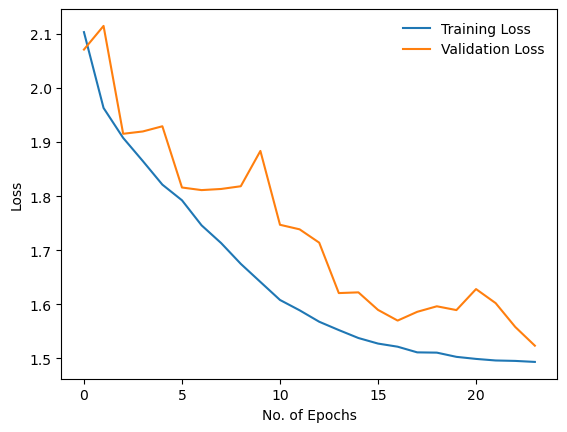

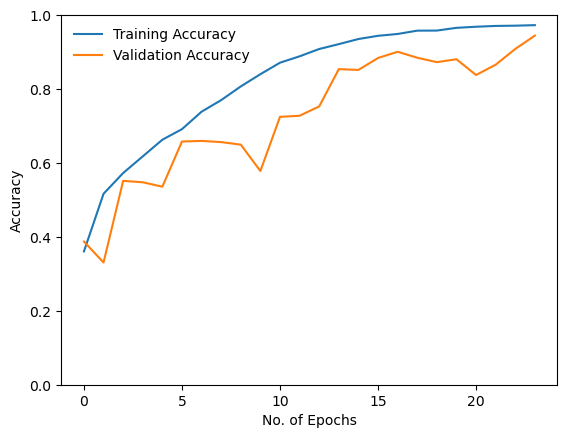

In [18]:
# Plot training/validation loss
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# Plot training/validation accuracy
plt.plot(train_accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.ylim([0., 1.]) # Limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()


In [19]:
test_accuracy, average_test_loss = validate(net, test_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(test_accuracy)/len(test_accuracy)))

Accuracy: 0.93


In [ ]:
model_export_path = "./SI_model/"
model_name = 'timeseries_multiclass_CNN.pth'
os.makedirs(model_export_path, exist_ok=True)

#Save Pytorch model
def save_net(net, model_path, model_name):
    # Save PyTorch model
    model_full_path = os.path.join(model_path, model_name)
    torch.save(net.state_dict(), model_full_path)
    print(f'Model saved to {model_full_path}')

# Example usage
save_net(net, model_export_path, model_name)